### Импорт библиотек, настройка



In [3]:
import torch
import os
from PIL import Image
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torchvision import transforms
import matplotlib.pyplot as plt
import torchvision
from torchvision.models.detection import maskrcnn_resnet50_fpn
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
import torch.optim as optim
import torch.nn as nn
from tqdm import tqdm
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [59]:
print(f'PyTorch version: {torch.__version__}')
print('*'*10)
print(f'_CUDA version: ')
!nvcc --version
print('*'*10)
print(f'CUDNN version: {torch.backends.cudnn.version()}')
print(f'Available GPU devices: {torch.cuda.device_count()}')
print(f'Device Name: {torch.cuda.get_device_name()}')

PyTorch version: 2.2.2
**********
_CUDA version: 
nvcc: NVIDIA (R) Cuda compiler driver**********
CUDNN version: 8801
Available GPU devices: 1
Device Name: NVIDIA GeForce GTX 1650 Ti

Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:41:10_Pacific_Daylight_Time_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0


In [60]:
# Пути данных
#DATA_DIR = "C:\\Users\\minik\\Desktop\\datasets\\dataset_tubulitis"
TRAIN_DATA = "C:\\Users\\minik\\Desktop\\datasets\\all_tubuli\\train"
VAL_DATA = "C:\\Users\\minik\\Desktop\\datasets\\all_tubuli\\val"
TEST_DATA = "C:\\Users\\minik\\Desktop\\datasets\\all_tubuli\\test"
TRAIN_DATA_AUG = "C:\\Users\\minik\\Desktop\\datasets\\all_tubuli\\train_aug"


In [61]:
transform_set = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
            ])

#Создаем класс для создания датасета, в котором используем аугментацию
#данных с помощью библиотеки Albumentation
class CustomDataset(Dataset):
    def __init__(self, img_path, msk_path, transform_set = transform_set):
        self.images_paths = os.path.join(img_path, 'images')
        self.masks_paths = os.path.join(msk_path, 'masks\\Tubulitis')
        self.image_filenames = os.listdir(self.images_paths)
        self.transform_set = transform_set


    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        image_name = self.image_filenames[idx]
        image_path = os.path.join(self.images_paths, image_name)
        mask_path = os.path.join(self.masks_paths, image_name)

        image = Image.open(image_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")
        mask = np.array(mask)
        mask = np.where(mask <158,1,0)
        # Normalize images and masks
        if self.transform_set:
            image = self.transform_set(image)
            mask = transforms.ToTensor()(mask)

        return image, mask

In [62]:
# Создаем датасеты для обучения
from torch.utils.data import ConcatDataset


original_train_dataset = CustomDataset(
    img_path=TRAIN_DATA,
    msk_path=TRAIN_DATA,
    transform_set=transform_set
)

#Здесь мы используем обычную функцию, чтобы перевести изображение в тензоры
#и нормализровать его
augmentation_train_dataset = CustomDataset(
    img_path = TRAIN_DATA_AUG,
    msk_path = TRAIN_DATA_AUG,
    transform_set=transform_set
)

#Формируем окончательный тренировочный датасет
train_dataset = ConcatDataset(
    [original_train_dataset, augmentation_train_dataset]
)


val_dataset = CustomDataset(
    img_path=VAL_DATA,
    msk_path=VAL_DATA,
    transform_set=transform_set
)
test_dataset = CustomDataset(
    img_path=TEST_DATA,
    msk_path=TEST_DATA,
    transform_set=transform_set
)




In [63]:
# Создаем генераторы изображений для последовательной подачи в модель
# для тренировки, чтобы избежать ошибок с оперативной памятью и улучшить
# скорость обучения

train_dataloader = DataLoader(train_dataset, batch_size=6, shuffle=True)


val_dataloader = DataLoader(val_dataset, batch_size=6, shuffle=False)


test_dataloader = DataLoader(test_dataset, batch_size=6, shuffle=False)




In [64]:
img, lab = next(iter(test_dataloader))
print(type(img))
print(img.shape)
print(lab.shape)


<class 'torch.Tensor'>
torch.Size([6, 3, 256, 256])
torch.Size([6, 1, 256, 256])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Feature batch shape: torch.Size([6, 3, 256, 256])
Labels batch shape: torch.Size([6, 1, 256, 256])


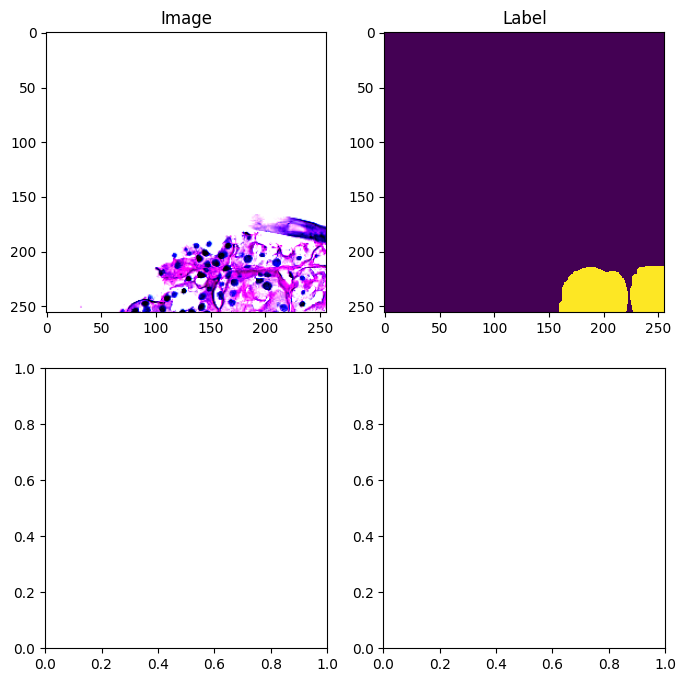

In [65]:
train_features, train_labels = next(iter(test_dataloader))
figure, ax = plt.subplots(nrows=2, ncols=2, figsize=(8,8))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze().T
label = train_labels[0]
ax[0, 0].imshow(img, cmap="gray")
ax[0, 0].set_title("Image")
ax[0, 1].set_title("Label")
ax[0, 1].imshow(label.T, interpolation="nearest")

### С этого момента неообходимо выбрать Архитектуру нейросети и произвести ее настройку


Семантическая бинарная сегментация

In [66]:
#!pip install -U segmentation-models-pytorch
#!pip install pytorch-lightning==1.9.3
import segmentation_models_pytorch as smp
import pytorch_lightning as pl


In [67]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [68]:
from tabulate import tabulate
from tqdm import tqdm
from collections import OrderedDict

In [69]:
from tabulate import tabulate
from tqdm import tqdm
from collections import OrderedDict

class DroneModel(pl.LightningModule):
    def __init__(self, model, optimizer, criterion):
        super().__init__()
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer

    def forward(self, x):
        return self.model(x)

    def shared_step(self, batch, stage):
        image, mask = batch
        out = self.forward(image)
        loss = self.criterion(out, mask.long())
        tp, fp, fn, tn = smp.metrics.get_stats((out.sigmoid() > 0.5).long(), mask.long(), mode='binary')
        iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro-imagewise")
        accuracy = smp.metrics.accuracy(tp, fp, fn, tn, reduction="micro-imagewise")
        recall = smp.metrics.recall(tp, fp, fn, tn, reduction="micro-imagewise")
        precision = smp.metrics.precision(tp, fp, fn, tn, reduction="micro-imagewise")
        self.log(f"{stage}_loss", loss, prog_bar=True, on_epoch=True)
        self.log(f"{stage}_IoU", iou, prog_bar=True, on_epoch=True)
        self.log(f"{stage}_Recall", recall, prog_bar=True, on_epoch=True)
        return {
            "loss": loss, "IoU": iou, "Accuracy": accuracy,
            "Recall": recall, "Precision": precision
            }

    def training_step(self, batch, batch_idx):
        return self.shared_step(batch, "train")

    def validation_step(self, batch, batch_idx):
        return self.shared_step(batch, "valid")

    def configure_optimizers(self):
        return self.optimizer

In [72]:
arch = 'unet'
enc_name = 'resnet50'
classes = 1

In [73]:


model = smp.create_model(arch,
                         encoder_name = enc_name,
                         encoder_weights = "imagenet",
                         in_channels = 3,
                         classes = classes).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-03)
criterion = criterion = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)
cbs = pl.callbacks.ModelCheckpoint(dirpath = f'C:\\Users\\minik\\Desktop\\Project\\Unet\\Tubul\\checkpoints_{arch}_new',
                                   filename = arch,
                                   verbose = True,
                                   monitor = 'valid_loss',
                                   mode = 'min')

In [49]:
pl_model = DroneModel(model, optimizer, criterion)
trainer = pl.Trainer(max_epochs=20, accelerator='auto', callbacks=cbs)
trainer.fit(pl_model, train_dataloader, val_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type     | Params
---------------------------------------
0 | model     | FPN      | 26.1 M
1 | criterion | DiceLoss | 0     
---------------------------------------
26.1 M    Trainable params
0         Non-trainable params
26.1 M    Total params
104.464   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Epoch 0: 100%|██████████| 3405/3405 [11:40<00:00,  4.86it/s, v_num=59, train_loss_step=1.000, train_IoU_step=0.000, train_Recall_step=0.000, valid_loss=0.775, valid_IoU=0.131, valid_Recall=0.493, train_loss_epoch=0.773, train_IoU_epoch=0.101, train_Recall_epoch=0.537]

Epoch 0, global step 3405: 'valid_loss' reached 0.77497 (best 0.77497), saving model to 'C:\\Users\\minik\\Desktop\\Project\\Unet\\Tubul\\checkpoints_fpn_new\\fpn.ckpt' as top 1


Epoch 1: 100%|██████████| 3405/3405 [12:00<00:00,  4.72it/s, v_num=59, train_loss_step=1.000, train_IoU_step=0.000, train_Recall_step=0.000, valid_loss=0.761, valid_IoU=0.135, valid_Recall=0.328, train_loss_epoch=0.681, train_IoU_epoch=0.100, train_Recall_epoch=0.299]    

Epoch 1, global step 6810: 'valid_loss' reached 0.76123 (best 0.76123), saving model to 'C:\\Users\\minik\\Desktop\\Project\\Unet\\Tubul\\checkpoints_fpn_new\\fpn.ckpt' as top 1


Epoch 2: 100%|██████████| 3405/3405 [11:52<00:00,  4.78it/s, v_num=59, train_loss_step=0.996, train_IoU_step=0.00178, train_Recall_step=0.0312, valid_loss=0.769, valid_IoU=0.141, valid_Recall=0.477, train_loss_epoch=0.644, train_IoU_epoch=0.104, train_Recall_epoch=0.273] 

Epoch 2, global step 10215: 'valid_loss' was not in top 1


Epoch 3: 100%|██████████| 3405/3405 [11:31<00:00,  4.92it/s, v_num=59, train_loss_step=0.982, train_IoU_step=0.00892, train_Recall_step=0.257, valid_loss=0.738, valid_IoU=0.163, valid_Recall=0.477, train_loss_epoch=0.627, train_IoU_epoch=0.109, train_Recall_epoch=0.264]   

Epoch 3, global step 13620: 'valid_loss' reached 0.73761 (best 0.73761), saving model to 'C:\\Users\\minik\\Desktop\\Project\\Unet\\Tubul\\checkpoints_fpn_new\\fpn.ckpt' as top 1


Epoch 4: 100%|██████████| 3405/3405 [11:35<00:00,  4.90it/s, v_num=59, train_loss_step=0.437, train_IoU_step=0.394, train_Recall_step=0.410, valid_loss=0.727, valid_IoU=0.172, valid_Recall=0.412, train_loss_epoch=0.621, train_IoU_epoch=0.116, train_Recall_epoch=0.274]    

Epoch 4, global step 17025: 'valid_loss' reached 0.72683 (best 0.72683), saving model to 'C:\\Users\\minik\\Desktop\\Project\\Unet\\Tubul\\checkpoints_fpn_new\\fpn.ckpt' as top 1


Epoch 5: 100%|██████████| 3405/3405 [11:27<00:00,  4.95it/s, v_num=59, train_loss_step=0.902, train_IoU_step=0.0517, train_Recall_step=0.332, valid_loss=0.752, valid_IoU=0.148, valid_Recall=0.483, train_loss_epoch=0.608, train_IoU_epoch=0.120, train_Recall_epoch=0.271]    

Epoch 5, global step 20430: 'valid_loss' was not in top 1


Epoch 6: 100%|██████████| 3405/3405 [11:19<00:00,  5.01it/s, v_num=59, train_loss_step=0.761, train_IoU_step=0.136, train_Recall_step=0.959, valid_loss=0.705, valid_IoU=0.177, valid_Recall=0.485, train_loss_epoch=0.603, train_IoU_epoch=0.126, train_Recall_epoch=0.277]     

Epoch 6, global step 23835: 'valid_loss' reached 0.70491 (best 0.70491), saving model to 'C:\\Users\\minik\\Desktop\\Project\\Unet\\Tubul\\checkpoints_fpn_new\\fpn.ckpt' as top 1


Epoch 7: 100%|██████████| 3405/3405 [11:49<00:00,  4.80it/s, v_num=59, train_loss_step=0.452, train_IoU_step=0.379, train_Recall_step=0.651, valid_loss=0.697, valid_IoU=0.182, valid_Recall=0.485, train_loss_epoch=0.594, train_IoU_epoch=0.132, train_Recall_epoch=0.281]     

Epoch 7, global step 27240: 'valid_loss' reached 0.69723 (best 0.69723), saving model to 'C:\\Users\\minik\\Desktop\\Project\\Unet\\Tubul\\checkpoints_fpn_new\\fpn.ckpt' as top 1


Epoch 8: 100%|██████████| 3405/3405 [12:01<00:00,  4.72it/s, v_num=59, train_loss_step=0.912, train_IoU_step=0.0469, train_Recall_step=0.552, valid_loss=0.719, valid_IoU=0.171, valid_Recall=0.477, train_loss_epoch=0.594, train_IoU_epoch=0.136, train_Recall_epoch=0.289]   

Epoch 8, global step 30645: 'valid_loss' was not in top 1


Epoch 9: 100%|██████████| 3405/3405 [11:22<00:00,  4.99it/s, v_num=59, train_loss_step=1.000, train_IoU_step=0.000, train_Recall_step=0.000, valid_loss=0.669, valid_IoU=0.202, valid_Recall=0.471, train_loss_epoch=0.587, train_IoU_epoch=0.139, train_Recall_epoch=0.285]     

Epoch 9, global step 34050: 'valid_loss' reached 0.66939 (best 0.66939), saving model to 'C:\\Users\\minik\\Desktop\\Project\\Unet\\Tubul\\checkpoints_fpn_new\\fpn.ckpt' as top 1


Epoch 10: 100%|██████████| 3405/3405 [11:19<00:00,  5.01it/s, v_num=59, train_loss_step=0.816, train_IoU_step=0.101, train_Recall_step=0.113, valid_loss=0.663, valid_IoU=0.210, valid_Recall=0.498, train_loss_epoch=0.581, train_IoU_epoch=0.148, train_Recall_epoch=0.299]     

Epoch 10, global step 37455: 'valid_loss' reached 0.66268 (best 0.66268), saving model to 'C:\\Users\\minik\\Desktop\\Project\\Unet\\Tubul\\checkpoints_fpn_new\\fpn.ckpt' as top 1


Epoch 11: 100%|██████████| 3405/3405 [11:18<00:00,  5.02it/s, v_num=59, train_loss_step=0.990, train_IoU_step=0.00516, train_Recall_step=0.612, valid_loss=0.680, valid_IoU=0.191, valid_Recall=0.501, train_loss_epoch=0.578, train_IoU_epoch=0.149, train_Recall_epoch=0.295]    

Epoch 11, global step 40860: 'valid_loss' was not in top 1


Epoch 12: 100%|██████████| 3405/3405 [11:19<00:00,  5.01it/s, v_num=59, train_loss_step=1.000, train_IoU_step=0.000, train_Recall_step=0.000, valid_loss=0.681, valid_IoU=0.195, valid_Recall=0.500, train_loss_epoch=0.574, train_IoU_epoch=0.153, train_Recall_epoch=0.300]    

Epoch 12, global step 44265: 'valid_loss' was not in top 1


Epoch 13: 100%|██████████| 3405/3405 [11:14<00:00,  5.05it/s, v_num=59, train_loss_step=0.513, train_IoU_step=0.322, train_Recall_step=0.335, valid_loss=0.683, valid_IoU=0.198, valid_Recall=0.478, train_loss_epoch=0.571, train_IoU_epoch=0.155, train_Recall_epoch=0.299]    

Epoch 13, global step 47670: 'valid_loss' was not in top 1


Epoch 14: 100%|██████████| 3405/3405 [11:10<00:00,  5.08it/s, v_num=59, train_loss_step=0.365, train_IoU_step=0.466, train_Recall_step=0.918, valid_loss=0.689, valid_IoU=0.197, valid_Recall=0.456, train_loss_epoch=0.567, train_IoU_epoch=0.158, train_Recall_epoch=0.299]     

Epoch 14, global step 51075: 'valid_loss' was not in top 1


Epoch 15: 100%|██████████| 3405/3405 [11:08<00:00,  5.10it/s, v_num=59, train_loss_step=1.000, train_IoU_step=0.000, train_Recall_step=0.000, valid_loss=0.669, valid_IoU=0.207, valid_Recall=0.492, train_loss_epoch=0.561, train_IoU_epoch=0.162, train_Recall_epoch=0.300]     

Epoch 15, global step 54480: 'valid_loss' was not in top 1


Epoch 16: 100%|██████████| 3405/3405 [11:07<00:00,  5.10it/s, v_num=59, train_loss_step=0.000, train_IoU_step=0.000, train_Recall_step=1.000, valid_loss=0.669, valid_IoU=0.206, valid_Recall=0.513, train_loss_epoch=0.561, train_IoU_epoch=0.165, train_Recall_epoch=0.306]     

Epoch 16, global step 57885: 'valid_loss' was not in top 1


Epoch 17: 100%|██████████| 3405/3405 [11:06<00:00,  5.11it/s, v_num=59, train_loss_step=0.187, train_IoU_step=0.685, train_Recall_step=0.810, valid_loss=0.695, valid_IoU=0.195, valid_Recall=0.459, train_loss_epoch=0.558, train_IoU_epoch=0.170, train_Recall_epoch=0.313]      

Epoch 17, global step 61290: 'valid_loss' was not in top 1


Epoch 18: 100%|██████████| 3405/3405 [11:07<00:00,  5.10it/s, v_num=59, train_loss_step=1.000, train_IoU_step=0.000, train_Recall_step=0.000, valid_loss=0.640, valid_IoU=0.230, valid_Recall=0.475, train_loss_epoch=0.554, train_IoU_epoch=0.175, train_Recall_epoch=0.314]     

Epoch 18, global step 64695: 'valid_loss' reached 0.64036 (best 0.64036), saving model to 'C:\\Users\\minik\\Desktop\\Project\\Unet\\Tubul\\checkpoints_fpn_new\\fpn.ckpt' as top 1


Epoch 19: 100%|██████████| 3405/3405 [11:07<00:00,  5.10it/s, v_num=59, train_loss_step=0.373, train_IoU_step=0.459, train_Recall_step=0.865, valid_loss=0.665, valid_IoU=0.213, valid_Recall=0.498, train_loss_epoch=0.549, train_IoU_epoch=0.177, train_Recall_epoch=0.313]     

Epoch 19, global step 68100: 'valid_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 3405/3405 [11:07<00:00,  5.10it/s, v_num=59, train_loss_step=0.373, train_IoU_step=0.459, train_Recall_step=0.865, valid_loss=0.665, valid_IoU=0.213, valid_Recall=0.498, train_loss_epoch=0.549, train_IoU_epoch=0.177, train_Recall_epoch=0.313]


### TESTING

In [50]:
PATH_TO_SAVE = "C:\\Users\\minik\\Desktop\\Project\\Unet\\Tubul\\tub.pth"
torch.save(model.state_dict(), PATH_TO_SAVE)

In [74]:
model = torch.load("C:\\Users\\minik\\Desktop\\Project\\Unet\\Tubul\\tub.pth")

In [75]:
cbs.best_model_path = "C:\\Users\\minik\\Desktop\\Project\\Unet\\Tubul\\checkpoints_unet\\unet.ckpt"

In [76]:
model = smp.create_model(arch,
                         encoder_name = enc_name,
                         encoder_weights = "imagenet",
                         in_channels = 3,
                         classes = classes).to(device)

state_dict = torch.load(cbs.best_model_path)['state_dict']
pl_state_dict = OrderedDict([(key[6:], state_dict[key]) for key in state_dict.keys()])

model.load_state_dict(pl_state_dict)
model.eval()

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      

In [77]:


## TESTING
with torch.no_grad():

    outputs = []
    test_loss = 0.0
    iou = 0

    for image, mask in tqdm(test_dataloader):

        image = image.to(device); mask = mask.to(device)
        output = model(image).to(device)
        tp, fp, fn, tn = smp.metrics.get_stats((output.sigmoid()>0.5).long(), mask.long(), mode='binary')

        outputs.append({"tp": tp, "fp": fp, "fn": fn, "tn": tn})
        loss = criterion(output, mask.long())
        test_loss += loss.item()

    tp = torch.cat([x["tp"] for x in outputs])
    fp = torch.cat([x["fp"] for x in outputs])
    fn = torch.cat([x["fn"] for x in outputs])
    tn = torch.cat([x["tn"] for x in outputs])

    print(f'Test Loss: {test_loss / len(test_dataloader)}')
    print('IoU:', smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro-imagewise").item())
    print('Accuracy:', smp.metrics.accuracy(tp, fp, fn, tn, reduction="micro-imagewise").item())

100%|██████████| 86/86 [00:07<00:00, 10.94it/s]

Test Loss: 0.26785345964653545
IoU: 0.5578296780586243
Accuracy: 0.7984441518783569


C:\Users\minik\AppData\Local\Temp\ipykernel_58572\982180702.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred = model(torch.tensor(image).unsqueeze(0).to(device))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input da

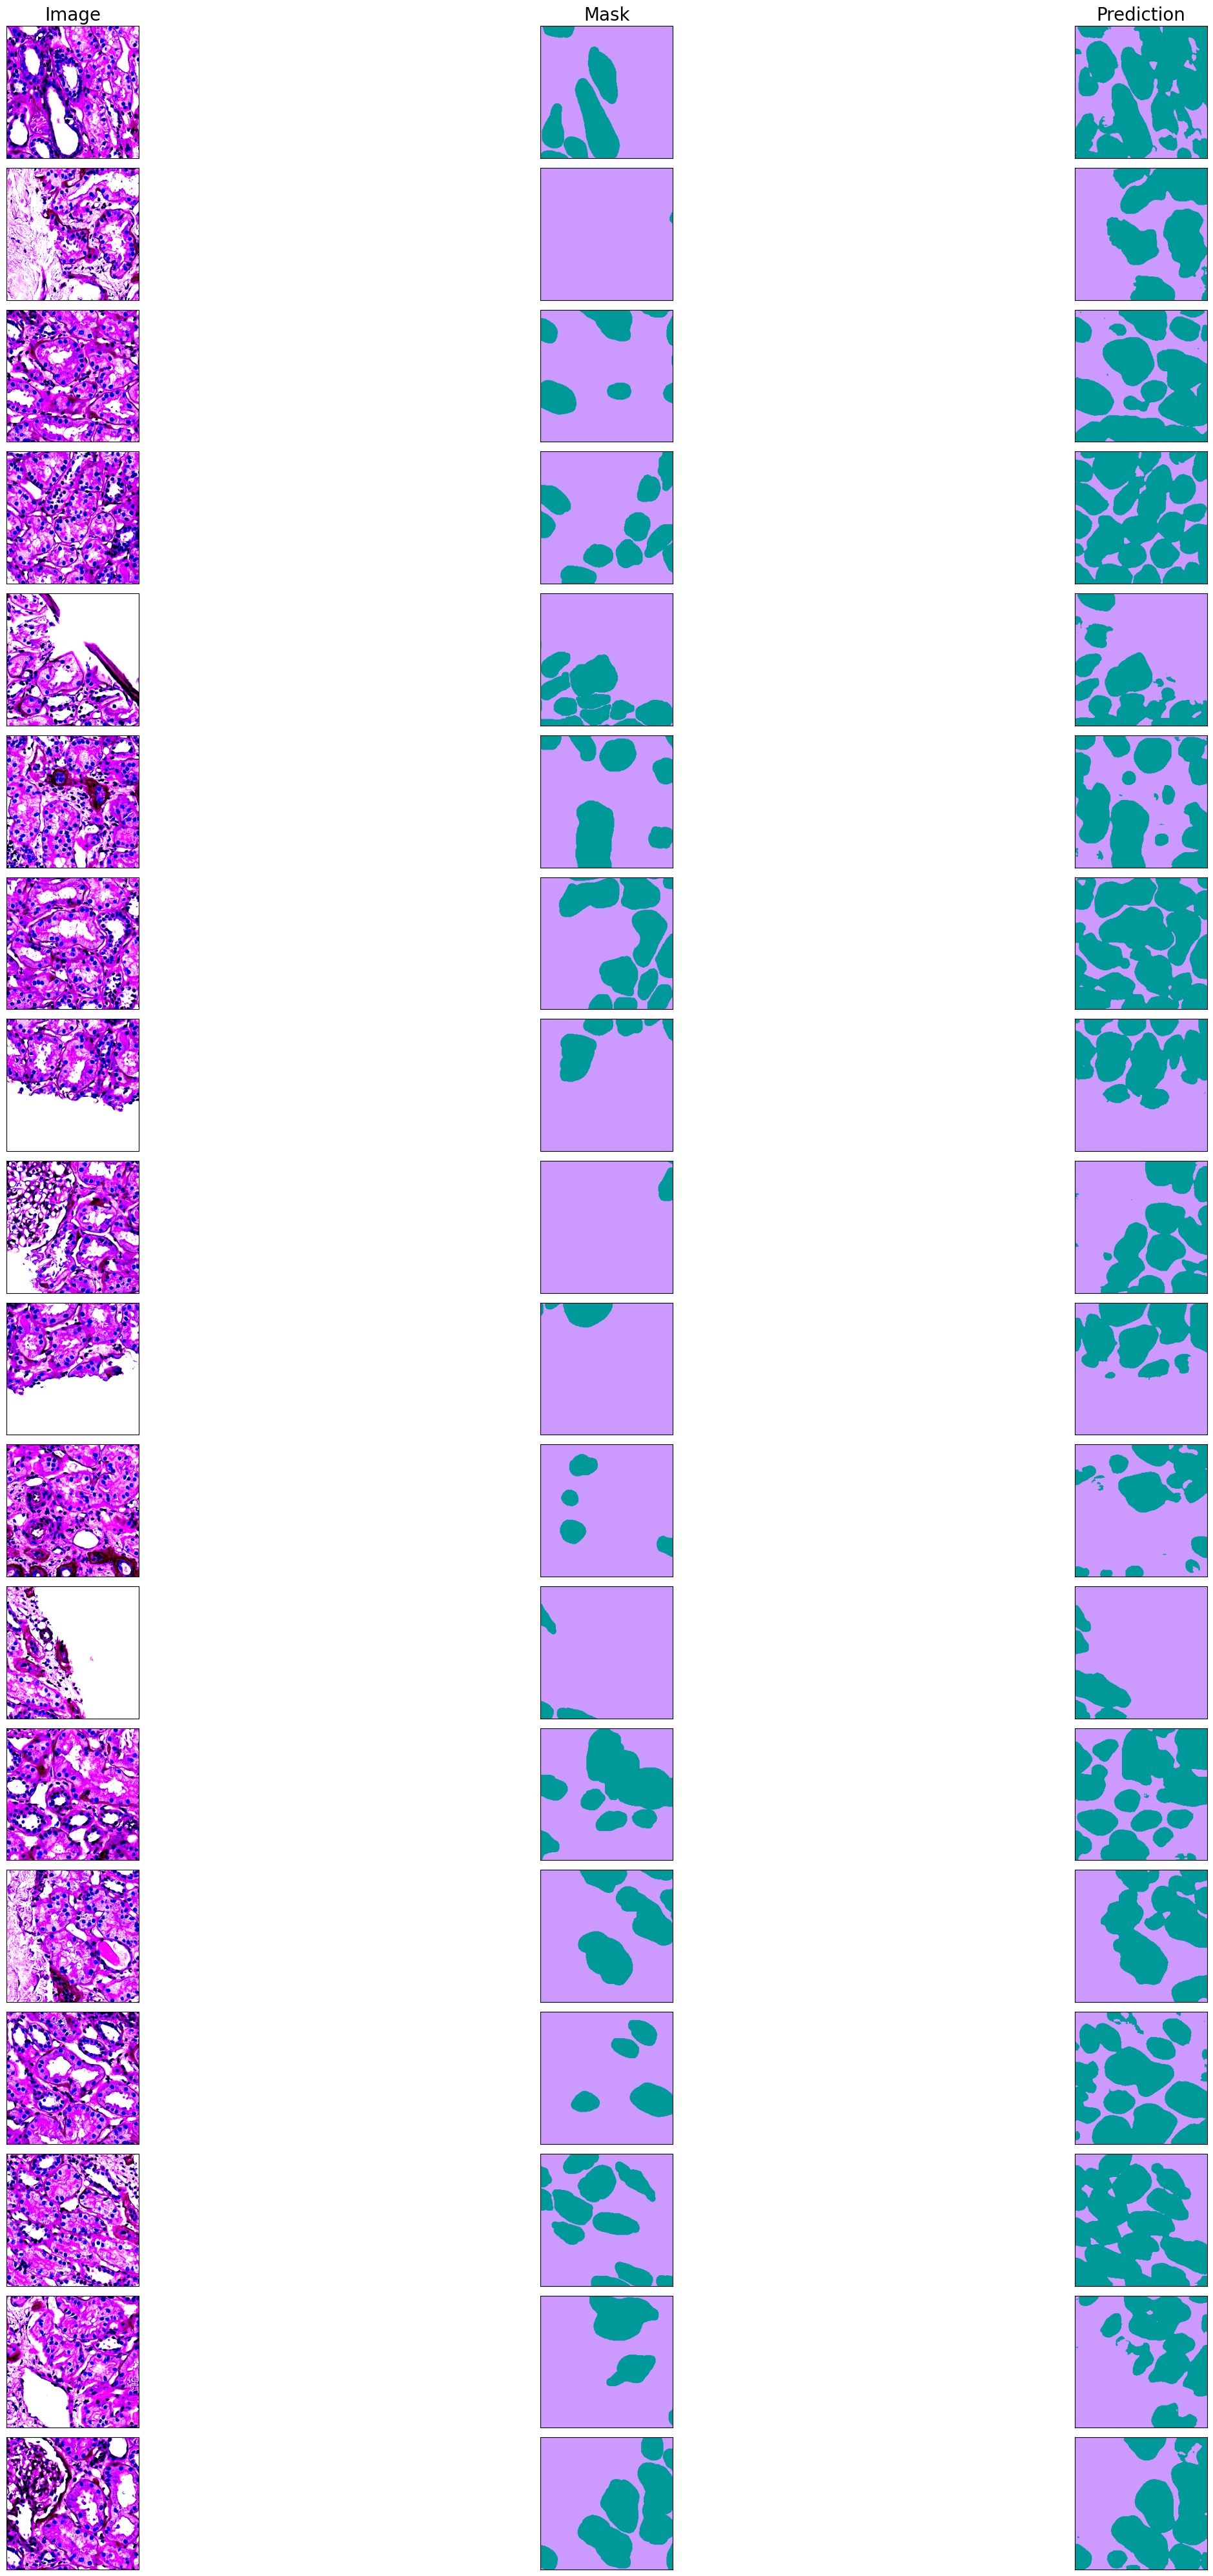

In [78]:
import random
random.seed(10)
samples = random.sample(range(len(test_dataloader)), 18)

palette = [[204,153,255], [0,153,153]]
pal = [value for color in palette for value in color]

cols = ['Image', 'Mask', 'Prediction']
fig, axes = plt.subplots(len(samples), 3, figsize=(60, 40), sharex='row', sharey='row',
                         subplot_kw={'xticks':[], 'yticks':[]}, tight_layout=True)

for ax, col in zip(axes[0], cols): ax.set_title(col, fontsize=20) # set column label --> considered epoch

i=0

for i in range(len(samples)):

        image, mask = test_dataset[samples[i]]
        pred = model(torch.tensor(image).unsqueeze(0).to(device))
        pred = (pred.sigmoid() > 0.5).long().squeeze(0)

        mask = Image.fromarray(mask.numpy().squeeze(0)).convert('L')
        pred = Image.fromarray(np.array(pred.squeeze(0).cpu()).astype('uint8')).convert('L')
        mask.putpalette(pal)
        pred.putpalette(pal)

        axes[i, 0].imshow(np.array(image).transpose(1, 2, 0), cmap='gray');
        axes[i, 1].imshow(mask);
        axes[i, 2].imshow(pred);

fig.savefig(arch + '.png')

In [79]:
metrics = np.round(torch.stack([torch.mean(smp.metrics.recall(tp, fp, fn, tn, reduction=None), 0),
                                torch.mean(smp.metrics.accuracy(tp, fp, fn, tn, reduction=None), 0),
                                torch.mean(smp.metrics.false_positive_rate(tp, fp, fn, tn, reduction=None), 0),
                                1 - torch.mean(smp.metrics.recall(tp, fp, fn, tn, reduction=None), 0),
                                torch.mean(smp.metrics.iou_score(tp, fp, fn, tn, reduction=None), 0),
                                torch.mean(smp.metrics.f1_score(tp, fp, fn, tn, reduction=None), 0)
                                ]).cpu().numpy(), 3)

info = {'Recall': metrics[0],
        'Accuracy':metrics[1],
        'FPR': metrics[2],
        'FNR': metrics[3],
        'IoU': metrics[4],
        'F1-Score': metrics[5]
        }

table = tabulate(info, headers='keys', tablefmt='fancy_grid')
print(table)

with open(f'{arch}.txt', 'w') as f:
    f.write(table)

╒══════════╤════════════╤═══════╤═══════╤═══════╤════════════╕
│   Recall │   Accuracy │   FPR │   FNR │   IoU │   F1-Score │
╞══════════╪════════════╪═══════╪═══════╪═══════╪════════════╡
│    0.892 │      0.798 │ 0.319 │ 0.108 │ 0.558 │      0.681 │
╘══════════╧════════════╧═══════╧═══════╧═══════╧════════════╛


loading Roboflow workspace...
loading Roboflow project...
{'predictions': [{'x': 126.0, 'y': 207.0, 'width': 4.0, 'height': 4.0, 'confidence': 0.760955810546875, 'class': 'MNL', 'class_id': 0, 'detection_id': 'f1dbc23f-53b1-422f-b051-e2fe583d1c3e', 'image_path': 'C:\\Users\\minik\\Desktop\\datasets\\all_tubuli\\test\\images\\image_test12.png', 'prediction_type': 'ObjectDetectionModel'}, {'x': 109.0, 'y': 43.0, 'width': 4.0, 'height': 4.0, 'confidence': 0.7597942352294922, 'class': 'MNL', 'class_id': 0, 'detection_id': 'e8842baf-5087-479a-8014-c5625ba0a671', 'image_path': 'C:\\Users\\minik\\Desktop\\datasets\\all_tubuli\\test\\images\\image_test12.png', 'prediction_type': 'ObjectDetectionModel'}, {'x': 235.0, 'y': 57.0, 'width': 4.0, 'height': 4.0, 'confidence': 0.7227498888969421, 'class': 'MNL', 'class_id': 0, 'detection_id': '464fc8f0-d747-4f61-82e5-88d962fbf6ed', 'image_path': 'C:\\Users\\minik\\Desktop\\datasets\\all_tubuli\\test\\images\\image_test12.png', 'prediction_type': 'Obje

SupervisionWarnings: from_roboflow is deprecated: `Detections.from_roboflow` is deprecated and will be removed in `supervision-0.22.0`. Use `Detections.from_inference` instead.
SupervisionWarnings: annotate is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


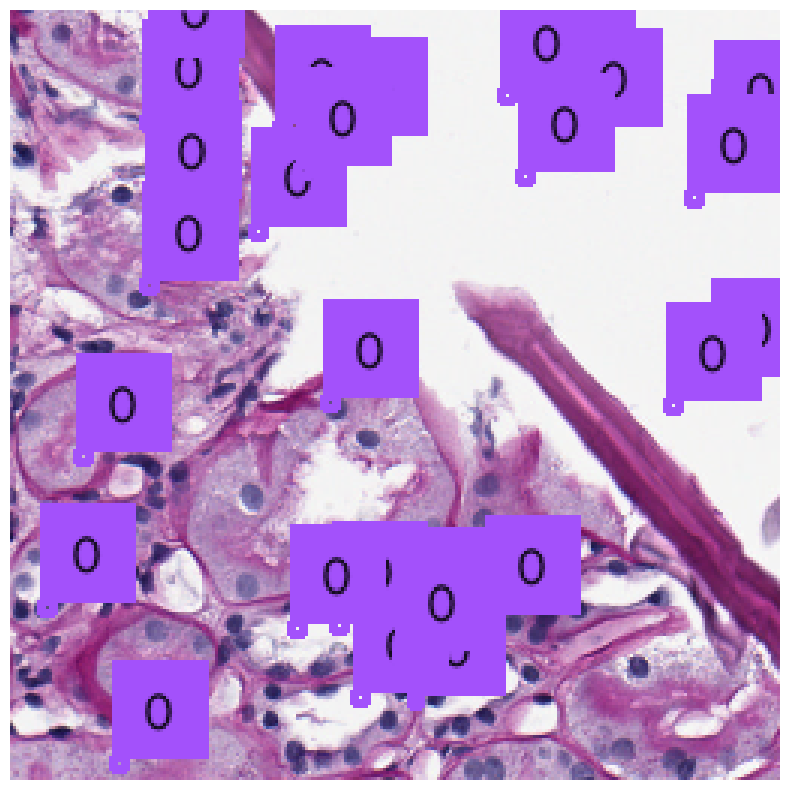

In [6]:
from roboflow import Roboflow
import supervision as sv
import cv2

rf = Roboflow(api_key="JAlc3jBAICvZVUpXXj7B")
project = rf.workspace().project("mnl")
model_yolo = project.version(5).model

result = model_yolo_save.predict("C:\\Users\\minik\\Desktop\\datasets\\all_tubuli\\test\\images\\image_test12.png", confidence=50, overlap=30).json()
print(result)
labels = [item["class"] for item in result["predictions"]]

detections = sv.Detections.from_roboflow(result)

label_annotator = sv.LabelAnnotator()
bounding_box_annotator = sv.BoxAnnotator()

image = cv2.imread("C:\\Users\\minik\\Desktop\\datasets\\all_tubuli\\test\\images\\image_test10.png")

annotated_image = bounding_box_annotator.annotate(
    scene=image, detections=detections)
#annotated_image = label_annotator.annotate(
#    scene=annotated_image, detections=detections, labels=labels)

sv.plot_image(image=annotated_image, size=(10, 10))

In [4]:
torch.save(model_yolo, "C:\\Users\\minik\\Desktop\\report\\Результаты\\Модели\\YOLO_Lympho\\model_yolov8_lymho.pt")


In [5]:
model_yolo_save = torch.load("C:\\Users\\minik\\Desktop\\report\\Результаты\\Модели\\YOLO_Lympho\\model_yolov8_lymho.pt")

tensor([[[[ -6.2960, -10.0065, -10.4045,  ..., -13.7248, -12.5491,  -8.1585],
          [ -8.5579, -13.8717, -14.3712,  ..., -22.3988, -20.3996, -12.9538],
          [ -9.4010, -15.3041, -15.8981,  ..., -26.3591, -24.2663, -15.3173],
          ...,
          [ 23.6368,  37.7173,  45.5041,  ...,  32.1291,  24.4331,  13.0499],
          [ 19.8870,  31.2145,  37.2530,  ...,  22.0575,  16.6347,   8.7704],
          [ 13.2925,  20.4269,  23.8491,  ...,  12.6162,   9.7371,   5.2417]]]],
       device='cuda:0', grad_fn=<ConvolutionBackward0>)


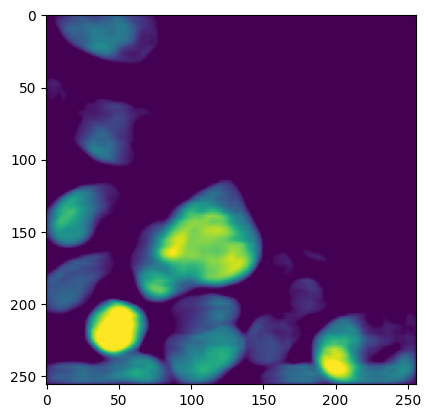

In [81]:
transform_set = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
            #transforms.Normalize(
            #    mean=[0.5],
            #    std=[0.5])
            ])

image_test = Image.open("C:\\Users\\minik\\Desktop\\datasets\\all_tubuli\\test\\images\\image_test10.png").convert("RGB")
image_test = transform_set(image_test)
image = image_test.to(device);

pred = model(image.unsqueeze(0))
print(pred)
pred = pred.squeeze().cpu().detach().numpy()
pred_img = Image.fromarray(pred).convert('L')

plt.imshow(pred_img)

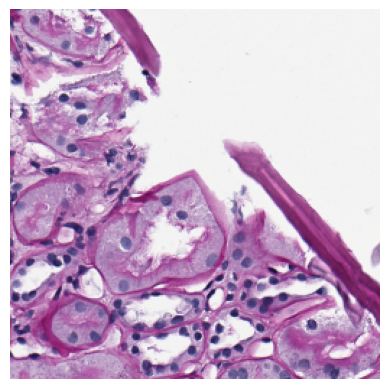

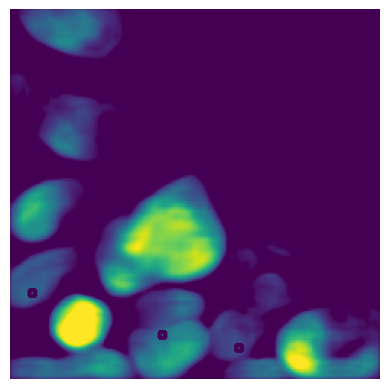

In [123]:
image = cv2.imread('C:\\Users\\minik\\Desktop\\datasets\\all_tubuli\\test\\images\\image_test10.png')

result = model_yolo.predict("C:\\Users\\minik\\Desktop\\datasets\\all_tubuli\\test\\images\\image_test10.png", confidence=30, overlap=1).json()
# Функция для преобразования координат bounding box из формата YOLO в формат OpenCV (x1, y1, x2, y2)
def yolo_to_cv(bb_yolo, img_width, img_height):
    x_center = bb_yolo['x']
    y_center = bb_yolo['y']
    width = bb_yolo['width']
    height = bb_yolo['height']
    
    x1 = int((x_center - width / 2))
    y1 = int((y_center - height / 2) )
    x2 = int((x_center + width / 2) )
    y2 = int((y_center + height / 2) )
    
    return x1, y1, x2, y2

# Создание списка bounding box'ов в формате OpenCV (x1, y1, x2, y2)
bounding_boxes = []
for prediction in result['predictions']:
    x1, y1, x2, y2 = yolo_to_cv(prediction, image.shape[0], image.shape[1])  # Используем правильные размеры img_width и img_height
    bounding_boxes.append((x1, y1, x2, y2))

def check_intersection(bb_cv, segmentation_mask):
    x1, y1, x2, y2 = bb_cv
    intersection = (np.sum(segmentation_mask[y1:y2, x1:x2]) / ((x2 - x1) * (y2 - y1)))*0.01 # Переводим в вероятность от 0 до 1
    return intersection > 0.5  # Процент пересечения больше 50% для считаемого совпадения

# Функция для отрисовки bounding box'ов на изображении
def draw_bounding_boxes(image, bounding_boxes, segmentation_mask):
    for bbox in bounding_boxes:
        x1, y1, x2, y2 = bbox
        if check_intersection(bbox, segmentation_mask):
            cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
            

# Отрисовка bounding box'ов на изображении
draw_bounding_boxes(image, bounding_boxes, pred)

# Отображение изображения с bounding box'ами
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

# Отрисовка bounding box'ов на маске
# Функция для отрисовки bounding box'ов на изображении
def draw_bounding_boxes_mask(image, bounding_boxes, segmentation_mask):
    #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    for bbox in bounding_boxes:
        x1, y1, x2, y2 = bbox
        if check_intersection(bbox, segmentation_mask):
            cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)  # Рисование bounding box'а

draw_bounding_boxes_mask(pred, bounding_boxes, pred)

# Отображение маски с bounding box'ами
plt.imshow(Image.fromarray(pred).convert('L'))
plt.axis('off')
plt.show()

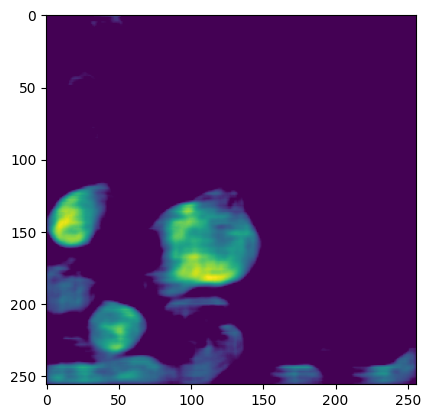

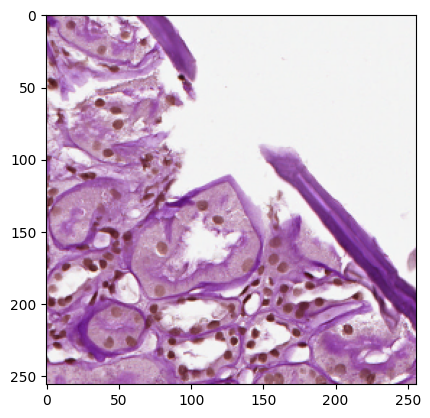

In [120]:
class EnsembleSegmentation:
    def __init__(self, yolo_model, unet_model):
        self.yolo_model = yolo_model
        self.unet_model = unet_model

    def predict(self, image_path, yolo_confidence=30, yolo_overlap=1):
        # Step 1: Detect objects using YOLO
        yolo_result = self.yolo_model.predict('C:\\Users\\minik\\Desktop\\datasets\\all_tubuli\\test\\images\\image_test10.png', confidence=yolo_confidence, overlap=yolo_overlap).json()
        
        bounding_boxes = []
        for prediction in yolo_result['predictions']:
            x1, y1, x2, y2 = yolo_to_cv(prediction, 256,256)  # Используем правильные размеры img_width и img_height
            bounding_boxes.append((x1, y1, x2, y2))  # Extract bounding boxes
        
        image = cv2.imread(image_path)
        
        
        # Step 2: Segment image using U-Net
        
        image_test = transform_set(image)
        image = image_test.to(device)
        unet_mask = self.unet_model.predict(image.unsqueeze(0))
        
        final_mask = self.adjust_mask_with_yolo(unet_mask, bounding_boxes)
        
        return final_mask

    def yolo_to_cv(self, bb_yolo, img_height=None, img_width=None):
        x_center = bb_yolo['x']
        y_center = bb_yolo['y']
        width = bb_yolo['width']
        height = bb_yolo['height']
    
        x1 = int((x_center - width / 2))
        y1 = int((y_center - height / 2) )
        x2 = int((x_center + width / 2) )
        y2 = int((y_center + height / 2) )

        return x1,y1,x2,y2
    
    def check_intersection(self, bbox, image):
        x1, y1, x2, y2 = bbox
        intersection = (np.sum(image[y1:y2, x1:x2]) / ((x2 - x1) * (y2 - y1)))*0.01 # Переводим в вероятность от 0 до 1
        return intersection  # Процент пересечения больше 50% для считаемого совпадения

    def adjust_mask_with_yolo(self, image, bounding_boxes):
        unet_mask_array = image.squeeze().cpu().detach().numpy()
        for bbox in bounding_boxes:
            x1, y1, x2, y2 = bbox
            intersection = np.sum(unet_mask_array[y1:y2, x1:x2]) / ((x2 - x1) * (y2 - y1))*0.01

            if intersection > 0.5:  # Или любой другой порог
                unet_mask_array[y1:y2, x1:x2] *= 3  # Увеличение веса пикселей в областях, где есть объекты
            else:
                unet_mask_array[y1:y2, x1:x2] *= 1
        return unet_mask_array

# Example usage
ensemble_model = EnsembleSegmentation(model_yolo, model)
image_path = 'C:\\Users\\minik\\Desktop\\datasets\\all_tubuli\\test\\images\\image_test10.png'
final_mask = ensemble_model.predict(image_path)

#final_mask
#final_mask = final_mask.squeeze().cpu().detach().numpy()
final_mask = Image.fromarray(final_mask).convert('L')

plt.imshow(final_mask)
plt.show()
plt.imshow(cv2.imread(image_path))